Etching...
..........................

/opt/homebrew/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return fun(*args, **kwargs)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


..................................................................................................................................................................................................................................................................................................................................................



/var/folders/x1/ll0b1ycj47bc9yfhq2vkyqvr0000gn/T/ipykernel_2474/1092891035.py:246: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


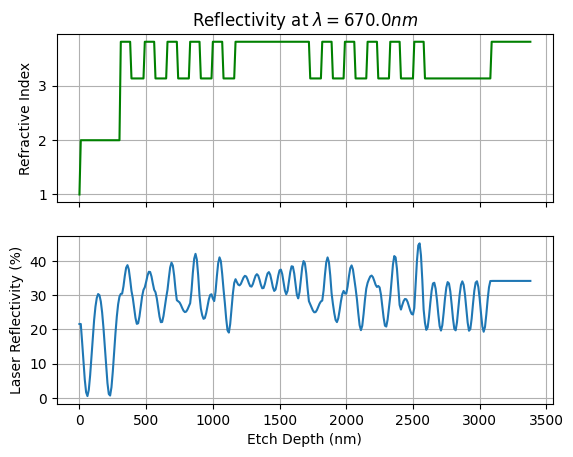

In [2]:
# -*- coding: utf-8 -*-
"""
    Simulate a laser etch monitor (aka. laser endpoint detection):
    Calculate the reflectivity of a thin-film stack as the stack is
    progressively thinned by etching from one side. Finally, plot
    reflectivity vs. etch depth at a single wavelength, as is often
    used to determine end-points during reactive ion/plasma etching.
    For more info, see Oxford Plasma's page on the technique:
        http://www.oxfordplasma.de/technols/li.htm

    Requires file `nk.py` for wavelength-dependent refractive index/loss models.

"""

from __future__ import print_function

# to make copies of Layer objects, instead of mutable references
from copy import copy, deepcopy

# for progress bar (sys.stdout)
import sys

import pylab
import numpy

import EMpy

# file of refractive indices, takes wavelengths in Microns!!
import nk


# Simulation Parameters
# laser monitor wavelength
wl_lasermon = 670e-9
# how much to etch before acquiring new laser monitor reflectivity
EtchStep = 10e-9

wls = numpy.array([wl_lasermon - 1e-9, wl_lasermon, wl_lasermon + 1e-9])
theta_inc = EMpy.utils.deg2rad(0)  # incidence angle


# Define some helper functions


def find_nearest(a, a0):
    """Return element in ndArray `a` that has value closest to the
    scalar value `a0`."""
    idx = numpy.abs(a - a0).argmin()
    return a.flat[idx]


def arg_find_nearest(a, a0):
    """Return index to element in ndArray `a` that has value closest
    to the scalar value `a0`."""
    idx = numpy.abs(a - a0).argmin()
    return idx


def count_noninf(multilayer):
    """Return number of non-infinite layers in an EMpy Multilayer
    object."""
    out = 0
    for x in multilayer:
        out = out + 0 if numpy.isinf(x.thickness) else out + 1
    return out


def arg_inf(multilayer):
    """Return index to layers with infinite-thickness in an EMpy Multilayer object."""
    out = []
    for ix, x in enumerate(multilayer):
        if numpy.isinf(x.thickness):
            out.append(ix)
    return out


# Define some materials

# Define RefractiveIndex functions, then Material objects.
n_air = 1.0  # constant vs. wavelength
mat_air = EMpy.materials.IsotropicMaterial(
    "air", EMpy.materials.RefractiveIndex(n0_const=n_air)
)

n_SiN = 1.997  # Silicon Nitride (Si3N4)
mat_SiN = EMpy.materials.IsotropicMaterial(
    "Si3N4", EMpy.materials.RefractiveIndex(n0_const=n_SiN)
)


# RIX functions from file, taking wavelength in microns:
# Covert to microns, request loss as complex refractive index
def n_GaAs(w):
    return nk.GaAs_interp(w * 1e6, k=True)


mat_GaAs = EMpy.materials.IsotropicMaterial(
    "GaAs", EMpy.materials.RefractiveIndex(n0_func=n_GaAs)
)


# Function from file, AlGaAs with 95% Aluminum
def n_AlGaAs95(w):
    return nk.AlGaAs_interp(0.95, w * 1e6, k=True)


mat_AlGaAs95 = EMpy.materials.IsotropicMaterial(
    "Al95Ga05As", EMpy.materials.RefractiveIndex(n0_func=n_AlGaAs95)
)


# DBR mirror periods, at 1/4-wavelength thicknesses
wl_center = 1100e-9
d_GaAs_DBR = wl_center / n_GaAs(wl_center).real / 4
d_AlGaAs_DBR = wl_center / n_AlGaAs95(wl_center).real / 4


# Build the Multilayer stack
# Build from top to bottom - ie. topmost layer (closest to laser
# monitor) first, substrate last.  Must include infinite-thickness
# layers on top & bottom for air & substrate, respectively.

Layer = EMpy.utils.Layer  # shortcut

# define the layers (material, thickness) we will use in the stack:
air = Layer(mat_air, numpy.inf)
SiN = Layer(mat_SiN, 300e-9)
GaAs_DBR = Layer(mat_GaAs, d_GaAs_DBR)
AlGaAs_DBR = Layer(mat_AlGaAs95, d_AlGaAs_DBR)
GaAs_core = Layer(mat_GaAs, 551.75e-9)
AlGaAs_spacer = Layer(mat_AlGaAs95, 500e-9)
GaAs_spacer = Layer(mat_GaAs, 300e-9)
GaAs_substrate = Layer(mat_GaAs, numpy.inf)

# Use lists to enable periodic structures etc.
#   Make sure to include infinite-thickness layers on ends
layers_ = (
    [air]
    + [SiN]
    + 5 * [GaAs_DBR, AlGaAs_DBR]
    + [GaAs_core]
    + 5 * [AlGaAs_DBR, GaAs_DBR]
    + [AlGaAs_spacer]
    + [GaAs_spacer]
    + [GaAs_substrate]
)

# Create EMpy MultiLayer stack.
#   Must dereference the lists from each other via copy(), otherwise altering
#   one layer during etching also affects other repeated Layers
layers = EMpy.utils.Multilayer([copy(l) for l in layers_])


# setup etching loop
EtchStep_current = EtchStep  # how much left to etch in current loop iteration
go = True  # while loop switch
i = -1  # while loop counter
etchedlayers = []  # save stacks of etched layers
solutions = []  # IsotropicTransferMatrix object storing R/T solutions
EtchSteps = []  # x-axis data
Rlaser = []  # y-axis data - reflectivity
RefrIdx = []  # y-axis data - refractive index
# get index to laser-monitor wavelength in `wls` array
wlidx = arg_find_nearest(wls, wl_lasermon)
# 0 if etching away from first layer in list, -1 if etching from last
# layer appended
idxtemp = 0

print("Etching...")
while go is True:
    # keep reducing thickness/removing layers until last layer is too thin
    i = i + 1

    # print a small progress bar
    sys.stdout.write(".")
    sys.stdout.flush()

    if count_noninf(layers) > 0:
        # at least one infinite-thickness layer should still be left

        if i <= 0:
            # first iteration: analyze unetched structure
            EtchStep_current = 0.0
            indexno = idxtemp
        else:
            # point to non-infinite layers for etching:
            while numpy.isinf(layers[idxtemp].thickness):
                idxtemp = idxtemp + 1  # assumes etching from 1st layer in list
            indexno = idxtemp

        if layers[indexno].thickness <= EtchStep_current:
            # next layer is thinner than etch step
            # Reduce etch step + remove this layer:
            EtchStep_current = EtchStep_current - layers[indexno].thickness
            layers.pop(indexno)

        elif layers[indexno].thickness > EtchStep_current:
            # etch increment ends within next layer
            # reduce layer thickness & solve & save data points:
            layers[indexno].thickness = layers[indexno].thickness - EtchStep_current
            # add this layer stack to the list
            etchedlayers.append(deepcopy(layers))
            # get RefrIndex in this layer
            RefrIdx.append(etchedlayers[-1][idxtemp].mat.n(wl_lasermon).real)
            if i <= 0:
                # for 1st iteration: unetched layer
                EtchSteps.append(0.0)
            else:
                EtchSteps.append(EtchSteps[-1] + EtchStep)  # Add x-axis point
                EtchStep_current = EtchStep  # reset EtchStep_current

            # solve for reflectivity at laser monitor wavelength
            solutions.append(
                EMpy.transfer_matrix.IsotropicTransferMatrix(
                    etchedlayers[-1], theta_inc
                ).solve(wls)
            )
            Rlaser.append(solutions[-1].Rs[wlidx])
    else:
        # No non-infinte layers left, end the loop
        go = False

print("\n")


# Plots:
fig1, [ax1, ax2] = pylab.subplots(nrows=2, ncols=1, sharex=True)
ax1.set_title(r"Reflectivity at $\lambda = %0.1fnm$" % (wls[wlidx] * 1e9))

# plot refractive index vs. depth
ax1.plot(numpy.array(EtchSteps) * 1e9, RefrIdx, "-g")
ax1.set_ylabel("Refractive Index")
ax1.grid(True)

# plot reflectivity vs. depth
ax2.plot(numpy.array(EtchSteps) * 1e9, numpy.array(Rlaser) * 100, "-")
ax2.set_ylabel("Laser Reflectivity (%)")
ax2.set_xlabel("Etch Depth (nm)")
ax2.grid(True)

fig1.show()
pylab.show()
